In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
sys.path.append("../")

import torch
from torch import nn
import torch.nn.functional as F

from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config
# from nupic.research.frameworks.pytorch.models.le_sparse_net import (
#     LeSparseNet
# )
from nupic.research.frameworks.continuous_learning.utils import clear_labels
from exp_lesparse import LeSparseNet

from nupic.torch.modules import (
    Flatten,
    KWinners,
    KWinners2d,
    SparseWeights,
    SparseWeights2d,
)

from nupic.research.frameworks.pytorch.model_utils import evaluate_model
from nupic.research.frameworks.continuous_learning.dendrite_layers import DendriteLayer

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
config_file = "../experiments.cfg"
with open(config_file) as cf:
    config_init = parse_config(cf)
    
cnn_pct_on = (0.25, 0.125) # default
cnn_weight_sparsity = (0.3, 0.2) # default

def adjust_sparsity(layer_size, pct_on):
    return max(pct_on/(layer_size/64), 0.02)

exp = "sparseCNN2"
config = config_init[exp]
config["name"] = exp
config["seed"] = np.random.randint(0,200)

aucs = np.zeros((2,2,3))
fcs = []
i,j,k = 0,0,0
use_dends = [False, True]
freeze_out = [False, True]
cnn_sizes = [256, 512, 1028]

for i in range(2):
    for j in range(2):
        for k in range(4):
            cnn_out = (cnn_sizes[k], cnn_sizes[k])

            config["cnn_out_channels"] = (cnn_out[0], cnn_out[1])
            config["cnn_percent_on"] = (adjust_sparsity(cnn_out[0],cnn_pct_on[0]),
                                        adjust_sparsity(cnn_out[1], cnn_pct_on[1]))
            config["cnn_weight_sparsity"] = (adjust_sparsity(cnn_out[0],cnn_weight_sparsity[0]),
                                             adjust_sparsity(cnn_out[1],cnn_weight_sparsity[1]))
            config["batch_size"] = 32
            config["use_dendrites"] = use_dends[i]
# config["boost_strength"] = 0.0
# config["boost_strength_factor"] = 0.0
# config["duty_cycle_period"] = 4000

            experiment = ContinuousSpeechExperiment(config)
            train_inds = np.arange(1,11).reshape(5,2)
            layer_type = "kwinner"
            for ind in range(len(train_inds)):
                experiment.train(1,train_inds[ind],
                                freeze_output=freeze_out[j],
                                layer_type=layer_type,
                                output_indices=clear_labels(train_inds[ind]))
            
            auc = experiment.get_auc()
            print("Dends: {}, Freeze: {}, cnn_size: {} - acc: {}, auc: {}".format(
                use_dends[i], freeze_out[j], cnn_sizes[k], 
                np.round(experiment.test()["mean_accuracy"],2),
                np.round(auc,2))
                 )
            aucs[i,j,k] = auc
            fcs.append(experiment.get_forgetting_curve())


1.5
1.5
Creating optimizer with learning rate= 0.01


In [3]:
experiment.train_entire_dataset(1)
experiment.test()

{'total_correct': 2150,
 'mean_loss': 4.241028525612571,
 'mean_accuracy': 84.24764890282131,
 'entropy': 76355.921875,
 'total_samples': 2552,
 'non_zero_parameters': 43489200}

In [6]:
train_inds = np.arange(1,11).reshape(5,2)
layer_type = "kwinner"
for j in range(len(train_inds)):
    experiment.train(1,train_inds[j],
                    freeze_output=False,
                    layer_type=layer_type,
                    output_indices=clear_labels(train_inds[j]))

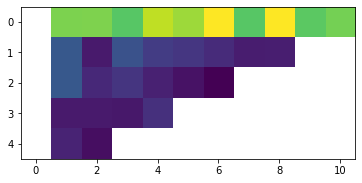

In [7]:
fc = experiment.get_forgetting_curve()
plt.imshow(fc)

Text(0.5, 0, '')

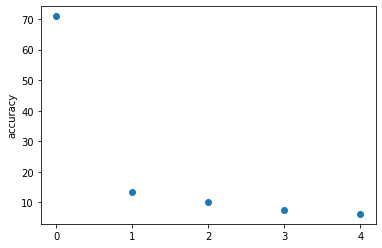

In [8]:
plt.plot(np.nanmean(fc, axis=1),'o');
plt.xticks(range(5))
plt.ylabel("accuracy")
plt.xlabel("")

In [9]:
np.trapz(np.nanmean(fc, axis=1))
from scipy.integrate import simps
simps(np.nanmean(fc, axis=1))

60.216222222222214

In [9]:
a =np.vstack(experiment.running_accuracy)

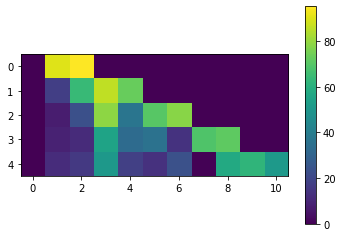

In [10]:
plt.imshow(a)
plt.colorbar();

In [11]:
b = np.vstack([np.roll(a[i,:], 8-2*i) for i in range(a.shape[0])])

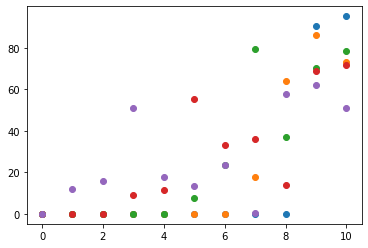

In [12]:
plt.plot(b.T,'o')

In [11]:
experiment.test()["mean_accuracy"]

18.064263322884013

In [19]:
print("Dends: {}, Freeze: {}, cnn_size: {} - acc: {}, auc: {}".format(
    use_dends, freeze_out, cnn_sizes, np.round(experiment.test()["mean_accuracy"],2),
                                              np.round(auc,2)))

Dends: False, Freeze: False, cnn_size: 256 - acc: 20.85, auc: 69.82


In [22]:
i,j,k

(1, 0, 1)